# `spectral_cube` Tests
Test out functionality of `spectral_cube` package for storing *Hinode*/EIS data. Current container takes way too long to build and the files are way too large. Try loading in some of our simulated EIS data to see if we can reduce the compute time and storage requirements.

In [1]:
import os

import numpy as np
import scipy.sparse
import h5py
import astropy.units as u
import astropy.wcs
import sunpy.map 
import spectral_cube
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import h5py

import synthesizAR
from synthesizAR.instruments import InstrumentHinodeEIS
from synthesizAR.util import EISCube

%matplotlib inline

/home/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# EIS Observation
Calculate EISCube spectral observation for $t=0$ s. Need to first calculate the LOS velocity and temperature and then supply that to `detect()` method on the EIS instrument. We'll do this for our low frequency run in our systematic study using AR 1109.

Load the field.

In [2]:
ar_root = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_low_frequency/'

In [3]:
field = synthesizAR.Skeleton.restore(os.path.join(ar_root,'field_checkpoint'))

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-04-19 20:14:39,705 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-04-19 20:14:39,705 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-04-19 20:14:39,706 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-04-19 20:14:39,707 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-04-19 20:14:39,708 Parameters: cosmological_simulation   = 0.0


Create the *Hinode*/EIS instrument.

In [4]:
eis = InstrumentHinodeEIS([5000,5100]*u.s)

Create the observer object.

In [5]:
observer = synthesizAR.Observer(field,[eis],ds=field._convert_angle_to_length(0.4*u.arcsec))

/home/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [6]:
observer.build_detector_files(ar_root)

Calculate the the LOS velocity and temperature.

In [7]:
los_velocity_map = observer.make_los_velocity_map(eis.observing_time[0],eis)

/home/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


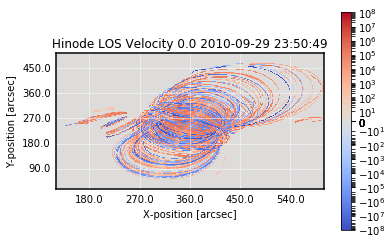

In [8]:
los_velocity_map.peek()

In [9]:
temperature_map = observer.make_temperature_map(eis.observing_time[0],eis)

/home/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


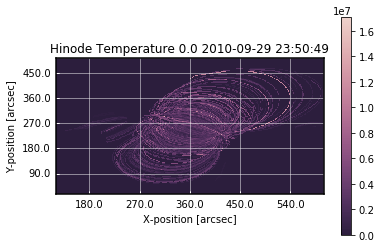

In [10]:
temperature_map.peek()

Create EISCube object.

In [11]:
header = eis.make_fits_header(field,eis.channels[0])
header['tunit'] = (u.s).to_string()
header['t_obs'] = eis.observing_time[0].value

In [12]:
with h5py.File(eis.counts_file,'r') as hf:
    eiscube = eis.detect(hf,eis.channels[0], 0, header, 
                         temperature_map.data*u.Unit(temperature_map.meta['bunit']),
                         los_velocity_map.data*u.Unit(los_velocity_map.meta['bunit']))

In [ ]:
eiscube.integrated_intensity.peek(norm=matplotlib.colors.SymLogNorm(1,10,1e3))

In [15]:
eiscube.save('/home/wtb2/Desktop/test_eiscube_small.h5',use_fits=False,
             #hdf5_save_params={'compression':None,'dtype':np.float64}
            )

In [16]:
cube_restore_big = EISCube('/home/wtb2/Desktop/test_eiscube.h5')

In [20]:
cube_restore_small = EISCube('/home/wtb2/Desktop/test_eiscube_small.h5')

In [18]:
cube_restore_fits = EISCube('/home/wtb2/Desktop/test_eiscube.fits')

In [48]:
eiscube.data.max()

<Quantity 59768.75629112809 cm cm ct g(1/2) / (Angstrom cm erg(1/2) pix s2)>

In [90]:
eiscube.data.unit.

Unit("cm cm ct g(1/2) / (Angstrom cm erg(1/2) pix s2)")

In [93]:
eiscube.data.unit.compose(units=[u.cm,u.ct,u.g,u.erg,u.angstrom,u.pixel,u.s])[0]

Unit("ct / (Angstrom pix s)")

In [84]:
u.cm.bases

[Unit("cm")]

In [67]:
count_equiv = [(u.ct,u.cgs, lambda x: x.value, lambda x: x.value)]

In [77]:
(1.*u.m).cgs

<Quantity 100.0 cm>

In [78]:
u.ct.compose(equivalencies=count_equiv)

TypeError: <module 'astropy.units.cgs' from '/home/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/astropy/units/cgs.py'> can not be converted to a Unit

## Saving `EISCube` objects

In [ ]:
os.path.splitext('/hello/foo/bar.fits')[-1]

In [ ]:
eiscube.save('/home/wtb2/Desktop/test_eiscube.fits.gz')

In [ ]:
test_data = eiscube.data.value#np.where(eiscube.data.value<1e-10,0.,eiscube.data.value)

In [ ]:
sparse_data = [scipy.sparse.csr_matrix(test_data[:,:,i]) for i in range(eiscube.wavelength.shape[0])]

In [ ]:
sd_data = np.array([sd.data for sd in sparse_data])
sd_indices = np.array([sd.indices for sd in sparse_data])
sd_indptr = np.array([sd.indptr for sd in sparse_data])

In [ ]:
ragged_type = h5py.special_dtype(vlen=np.dtype('float64'))

In [ ]:
with h5py.File('/home/wtb2/Desktop/test_eiscube.h5','w') as hf:
    grp = hf.create_group('meta')
    for key in eiscube.meta:
        grp.attrs[key] = eiscube.meta[key]
    dset_wvl = hf.create_dataset('wavelength',data=eiscube.wavelength.value)
    dset_wvl.attrs['units'] = eiscube.wavelength.unit.to_string()
    dset_intens = hf.create_dataset('intensity',data=eiscube.data.value,
                                  compression='gzip',dtype=np.float32,
                                 )
    dset_intens.attrs['units'] = eiscube.data.unit.to_string()

In [ ]:
with h5py.File('/home/wtb2/Desktop/test_eiscube.h5','r') as hf:
    test_data_from_file = np.array(hf['intensity'])

In [ ]:
np.all(test_data_from_file == eiscube.data.value)

In [ ]:
test_sparse.toarray() == test_data[:,:,20]

In [ ]:
reconstructed_cube = EISCube('')

## Spectral Cube
Now, can we translate the EIS data into a spectral cube?

In [ ]:
test_specube = spectral_cube.SpectralCube(eiscube.data,astropy.wcs.WCS(eiscube.meta))

In [ ]:
scipy.sparse.lil_matrix(sparse_data[20])

In [ ]:
test_mm = sunpy.map.MapMeta()

In [ ]:
test_mm['naxis_1'] = 2999

In [ ]:
test_mm

In [ ]:
eiscube[0].meta

In [ ]:
eiscube[0].data.shape